# Calculate zones and levels


In [1]:
# import needed libraries
import open3d as o3d
import pandas as pd
from scipy.spatial import Delaunay
import numpy as np
from copy import deepcopy as copy
from tqdm import tqdm

Zone-1 already define by user since it is the source of information.

In [2]:
# open and read the model file
# use your own directory to dataset
interprets = "C:/Users/r04ra18/Documents/Coding/cfv1/v7/v7/hor1-6.csv"

# Define the uncertainty distance between the data source (100 m) on the y-direction due to separation, scale and complicity.
# here define the distance between outcrops and boreholes that define zone-2.
y_dist = 100

# open and read the data source files
# Define the uncertainty distance (100 m) on the x-direction due to separation, scale and complicity
geoclass = {
    "C:/Users/r04ra18/Documents/Coding/cfv1/v7/v7/tw1.csv":50,
    "C:/Users/r04ra18/Documents/Coding/cfv1/v7/v7/tw2.csv":50,
    "C:/Users/r04ra18/Documents/Coding/cfv1/v7/v7/tw3.csv":50,
    "C:/Users/r04ra18/Documents/Coding/cfv1/v7/v7/tw4.csv":50,
    "C:/Users/r04ra18/Documents/Coding/cfv1/v7/v7/tw5.csv":50,
    "C:/Users/r04ra18/Documents/Coding/cfv1/v7/v7/tw6.csv":50,
    "C:/Users/r04ra18/Documents/Coding/cfv1/v7/v7/tw7.csv":50,
    "C:/Users/r04ra18/Documents/Coding/cfv1/v7/v7/tw8.csv":50,
    "C:/Users/r04ra18/Documents/Coding/cfv1/v7/v7/tw9.csv":50,
    "C:/Users/r04ra18/Documents/Coding/cfv1/v7/v7/tw10.csv":50,
    "C:/Users/r04ra18/Documents/Coding/cfv1/v7/v7/tw11.csv":50,
    "C:/Users/r04ra18/Documents/Coding/cfv1/v7/v7/tw12.csv":50,
    "C:/Users/r04ra18/Documents/Coding/cfv1/v7/v7/tw13.csv":50,
    "C:/Users/r04ra18/Documents/Coding/cfv1/v7/v7/oc1.csv":50,
    "C:/Users/r04ra18/Documents/Coding/cfv1/v7/v7/oc2.csv":50,
    "C:/Users/r04ra18/Documents/Coding/cfv1/v7/v7/oc3.csv":50,
}

In [3]:
# Read the columns of x, y & z values of the csv file assigned to the variable ‘interprets’. 
# Read a comma-separated values (csv) file into DataFrame.
# Create a PointCloud class, consists of point coordinates, and point colors.
# Convert float64 numpy array of shape (n, 3) to Open3D format.
# paint_uniform_color paints all the points to a uniform color. The color is in RGB space, [0, 1] range.
# calculate the number of points using the len() function.

interprets_pc = pd.read_csv(interprets, usecols = ["x", "y", "z"])
interprets_pc_pts = interprets_pc.values
interprets_pcd = o3d.geometry.PointCloud()
interprets_pcd.points = o3d.utility.Vector3dVector(interprets_pc_pts)
interprets_pcd.paint_uniform_color([0, 0, 1.0])

# we clculate the number of points using the len() function to returns the number of point in our zone 
# and return a new array of given shape and type, filled with zeros.

shortest_distances = np.zeros((len(list(geoclass.keys())), len(interprets_pc_pts)))

# we use the for loop to iterate through the data source and return a new array (x,y) of given shape and type, filled with zeros.
# we use the enumerate() method adds counter to an iterable and returns it (the enumerate object).
# Read the columns of x, y & z values of the csv file assigned to the variable ‘uncertainty_distance’. 
# Read a comma-separated values in (csv) file into DataFrame.
# Create a PointCloud class of outcrops, vertical and horizontal wells. 
# A point cloud consists of point coordinates, and optionally point colors and point normals.
# Convert float64 numpy array of shape (n, 3) to Open3D format.
# Convert the input to an array and Returns the indices that would sort an array and return a sorted copy of an array.

for idx, key in enumerate(geoclass.keys()):
    geoclass_pc_pts = pd.read_csv(key, usecols = ["x", "y", "z"]).values
    # print("geoclass_pc_pts", target_pc_pts.shape)
    geoclass_pcd = o3d.geometry.PointCloud()
    geoclass_pcd.points = o3d.utility.Vector3dVector(geoclass_pc_pts)
    distances = np.asarray(interprets_pcd.compute_point_cloud_distance(geoclass_pcd))
    shortest_distances[idx] = distances
two_min = np.argsort(shortest_distances, axis = 0)[:2]
shortest_distances = np.sort(shortest_distances,axis = 0)
valid_distances = np.sum(shortest_distances[:2], axis = 0) <= y_dist

def in_hull(p, hull):
        if not isinstance(hull,Delaunay):
            hull = Delaunay(hull)

        return hull.find_simplex(p)>=0

lies_or_not = {}
for idx, key in enumerate(geoclass.keys()):
    for jdx, jkey in enumerate(geoclass.keys()):
        if idx != jdx:
            hull_points = np.vstack((pd.read_csv(key, usecols = ["x", "y", "z"]).values, \
                                    pd.read_csv(jkey, usecols = ["x", "y", "z"]).values))
            lies_or_not[str(idx)+str(jdx)] = in_hull(interprets_pc_pts,hull_points)

total_ans = np.zeros(len(interprets_pc_pts))
geometries = []
keys = list(geoclass.keys())
for key in tqdm(geoclass.keys()):
    geoclass_pc_pts = pd.read_csv(key, usecols = ["x", "y", "z"]).values
    geoclass_pcd = o3d.geometry.PointCloud()
    geoclass_pcd.points = o3d.utility.Vector3dVector(geoclass_pc_pts)
    geoclass_pcd.paint_uniform_color([1.0, 0, 0])

    geoclass[key]+=0.01
    sphere_mesh = o3d.geometry.TriangleMesh.create_sphere(geoclass[key],10)
    sphere_pts = np.asarray(np.asarray(sphere_mesh.vertices))
    sphere = o3d.geometry.PointCloud()
    sphere.points = o3d.utility.Vector3dVector(sphere_pts)

    to_expand_pcd = copy(geoclass_pcd)
    to_expand_pcd_pts = np.asarray(to_expand_pcd.points)
    expanded_pts = np.array([[to_expand_pcd_pts[0][0],to_expand_pcd_pts[0][1],to_expand_pcd_pts[0][2]]])
    for i in to_expand_pcd_pts:
        expanded_pts = np.vstack((expanded_pts, i+sphere_pts))

    expanded_pcd = o3d.geometry.PointCloud()
    expanded_pcd.points = o3d.utility.Vector3dVector(expanded_pts)

    hull, _ = expanded_pcd.compute_convex_hull()
    hull_ls = o3d.geometry.LineSet.create_from_triangle_mesh(hull)
    hull_ls.paint_uniform_color((0, 1, 1)) #looseboundgraphicCYAN

    hull_hard, _ = geoclass_pcd.compute_convex_hull()
    hull_ls_hard = o3d.geometry.LineSet.create_from_triangle_mesh(hull_hard)
    hull_ls_hard.paint_uniform_color((1, 0, 0)) #rigidboundRED

    def in_hull(p, hull):
        if not isinstance(hull,Delaunay):
            hull = Delaunay(hull)

        return hull.find_simplex(p)>=0

    ans_losen = in_hull(interprets_pc_pts, expanded_pts)
    ans_hard = in_hull(interprets_pc_pts, geoclass_pc_pts)

    for i in range(len(total_ans)):
        # hull_points = np.vstack((pd.read_csv(keys[two_min[0][i]], usecols = ["x", "y", "z"]).values, \
        #                         pd.read_csv(keys[two_min[1][i]], usecols = ["x", "y", "z"]).values))
        # print(hull_points.shape)
        if valid_distances[i] == True and total_ans[i] != 1 and lies_or_not[str(two_min[0][i])+str(two_min[1][i])][i]:
            total_ans[i] = 2
        if ans_hard[i] == True:
            total_ans[i] = 1
        if ans_hard[i] == False and ans_losen[i] == True and total_ans[i] != 1:
            total_ans[i] = 3
        if ans_hard[i] == False and ans_losen[i] == False and interprets_pc_pts[i][-1] > 0 and total_ans[i] != 1:
            total_ans[i] = 5
    if geoclass[key] != 0.01:
        geometries.append(hull_ls)
    geometries.append(hull_ls_hard)

interprets_pcd_true = o3d.geometry.PointCloud()
interprets_pcd_true.points = o3d.utility.Vector3dVector(interprets_pc_pts[total_ans == 1])
interprets_pcd_false = o3d.geometry.PointCloud()
interprets_pcd_false.points = o3d.utility.Vector3dVector(interprets_pc_pts[total_ans == 0])
interprets_pcd_losen = o3d.geometry.PointCloud()
interprets_pcd_losen.points = o3d.utility.Vector3dVector(interprets_pc_pts[total_ans == 3])
interprets_pcd_false_zpos = o3d.geometry.PointCloud()
interprets_pcd_false_zpos.points = o3d.utility.Vector3dVector(interprets_pc_pts[total_ans == 5])
interprets_pcd_y = o3d.geometry.PointCloud()
interprets_pcd_y.points = o3d.utility.Vector3dVector(interprets_pc_pts[total_ans == 2])

interprets_pcd_true.paint_uniform_color([0, 1, 0])   #inside/1
interprets_pcd_false.paint_uniform_color([0.698, 0.133, 0.133])  #outside/0
interprets_pcd_false_zpos.paint_uniform_color([0.5, 0.5, 0.5])  #outsidepos/5
interprets_pcd_losen.paint_uniform_color([1, 0, 1])  #within100/2
interprets_pcd_y.paint_uniform_color([0, 0, 1])  #within_y
geometries.append(interprets_pcd_true)
geometries.append(interprets_pcd_false)
geometries.append(interprets_pcd_losen)
geometries.append(interprets_pcd_y)
geometries.append(interprets_pcd_false_zpos)

o3d.visualization.draw_geometries(geometries)
o3d.visualization.draw_geometries([interprets_pcd_true, interprets_pcd_false, interprets_pcd_false_zpos, interprets_pcd_losen, interprets_pcd_y])

interprets_pc_add = pd.read_csv(interprets)
interprets_pc_add['uncertaintyclasses'] = total_ans
interprets_pc_add.to_csv("level_1to5.csv")
df = pd.read_csv('level_1to5.csv')

level_1 = df[df['uncertaintyclasses']==1]
level_2 = df[df['uncertaintyclasses']==2]
level_3 = df[df['uncertaintyclasses']==3]
level_4 = df[df['uncertaintyclasses']==0]
level_5 = df[df['uncertaintyclasses']==5]

level_1.to_csv('level_1.csv', index=False)
level_2.to_csv('level_2.csv', index=False)
level_3.to_csv('level_3.csv', index=False)
level_4.to_csv('level_4.csv', index=False)
level_5.to_csv('level_5.csv', index=False)

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [09:44<00:00, 36.56s/it]
C:\Users\r04ra18\Anaconda3\envs\geocomp\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\r04ra18\Anaconda3\envs\geocomp\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


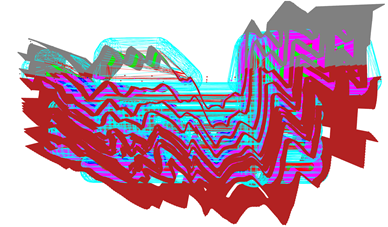

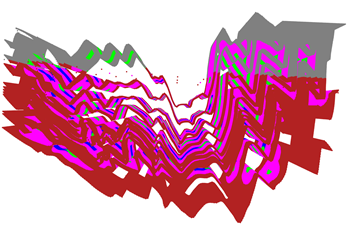